In [1]:
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon, LineString, Point
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Import top 20 cities by population file
urban_areas = gpd.read_file('/Users/lily/Documents/GitHub/parking_lots/states/20_cities.geojson')

# Create list of city names
ua_names = urban_areas['NAME10']
cities_states = []
for i in range(len(ua_names)):
    cities_states.append(ua_names[i])
cities_states

['Indianapolis,  Indiana',
 'Jacksonville, Florida',
 'Seattle, Washington',
 'Charlotte, North Carolina',
 'Houston, Texas',
 'Denver,  Colorado',
 'Columbus, Ohio',
 'San Francisco, California',
 'San Jose, California',
 'San Diego, California',
 'New York, New York',
 'Philadelphia, Pennsylvania',
 'Dallas, Texas',
 'El Paso, Texas',
 'Chicago, Illinois',
 'Los Angeles, California',
 'Phoenix, Arizona',
 'San Antonio, Texas',
 'Austin, Texas',
 'Washington, DC']

In [5]:
# Correct cities list to only contain the city names without the state attached
import re
cities = []
for i in range(len(cities_states)):
    get_name = cities_states[i]
    fixed_name = re.sub(r',[^,]*$', '', get_name)
    cities.append(fixed_name)
cities

['Indianapolis',
 'Jacksonville',
 'Seattle',
 'Charlotte',
 'Houston',
 'Denver',
 'Columbus',
 'San Francisco',
 'San Jose',
 'San Diego',
 'New York',
 'Philadelphia',
 'Dallas',
 'El Paso',
 'Chicago',
 'Los Angeles',
 'Phoenix',
 'San Antonio',
 'Austin',
 'Washington']

In [14]:
# Pop these indices in this order to correct the cities list -- 3,4,5,6,6,11,11,12,5
cities_states.pop(5)
cities.pop(5)

'San Jose'

In [15]:
def convert_wgs_to_utm(lon, lat):
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code

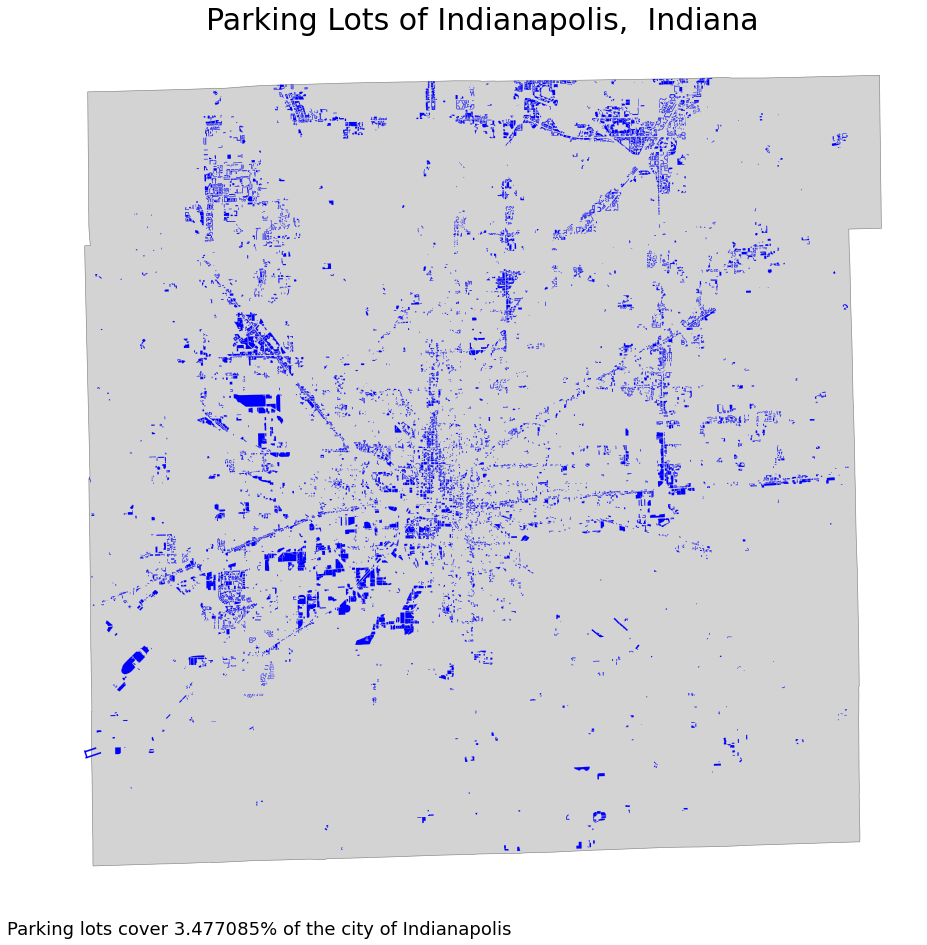

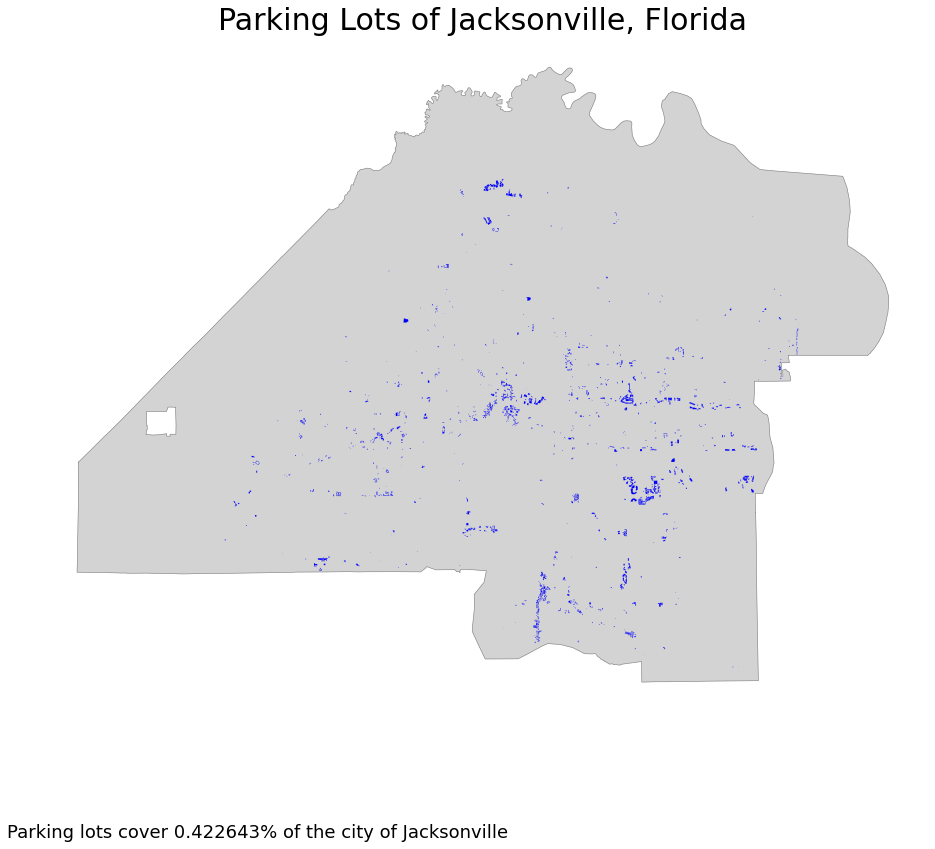

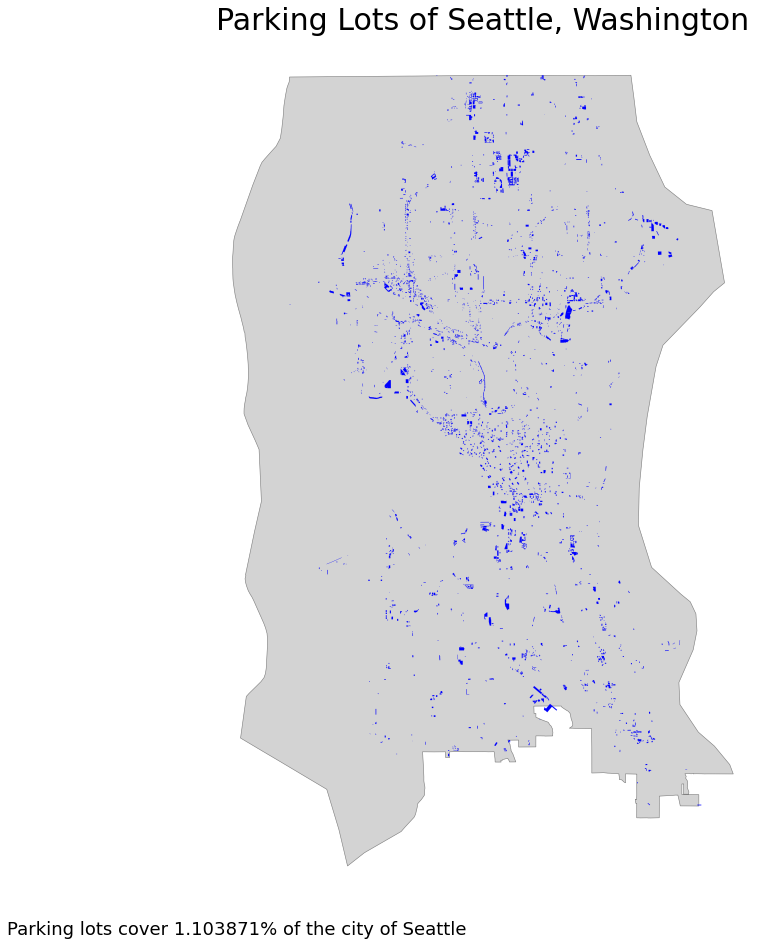

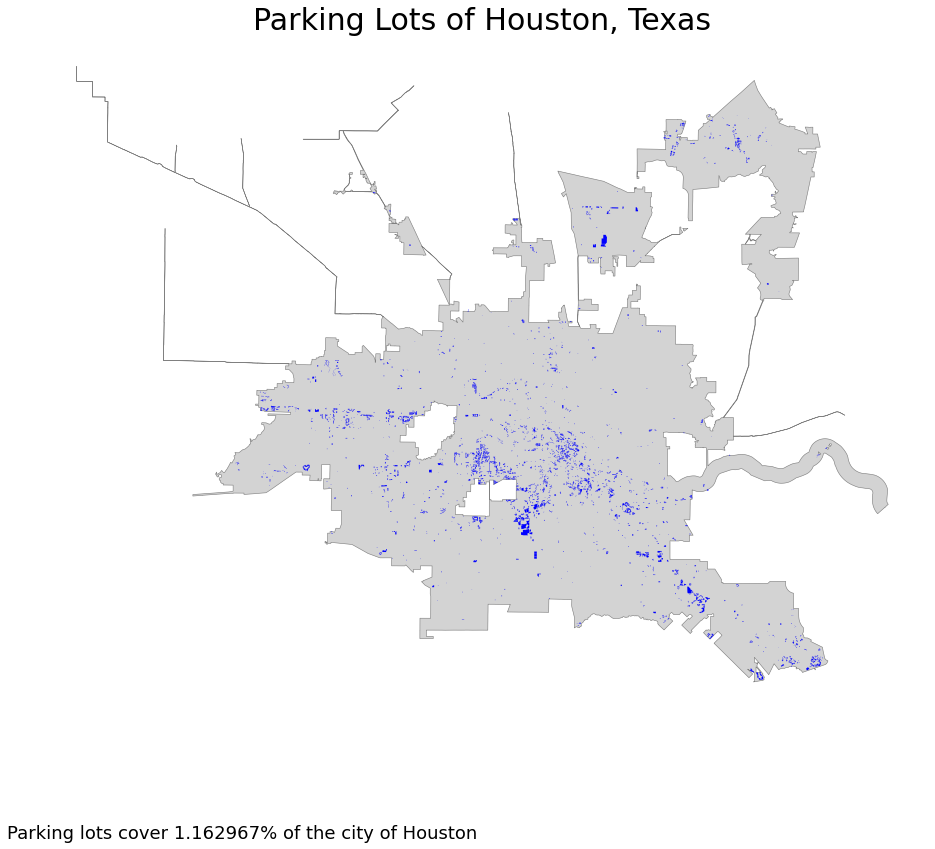

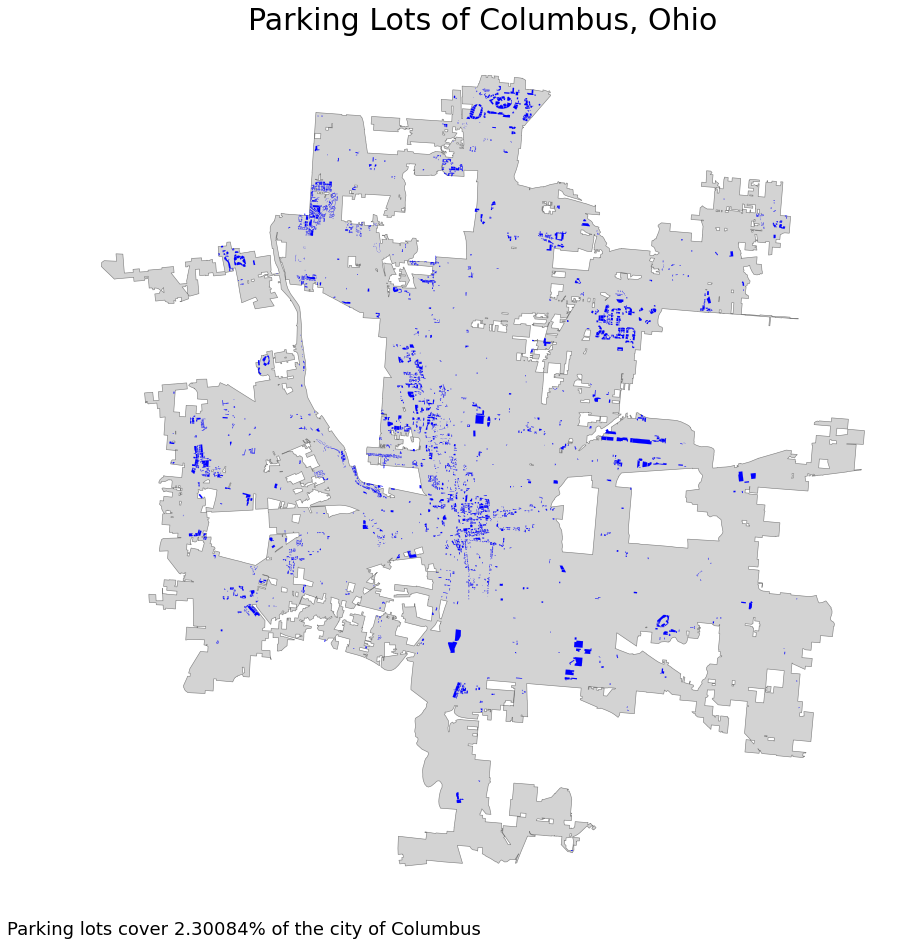

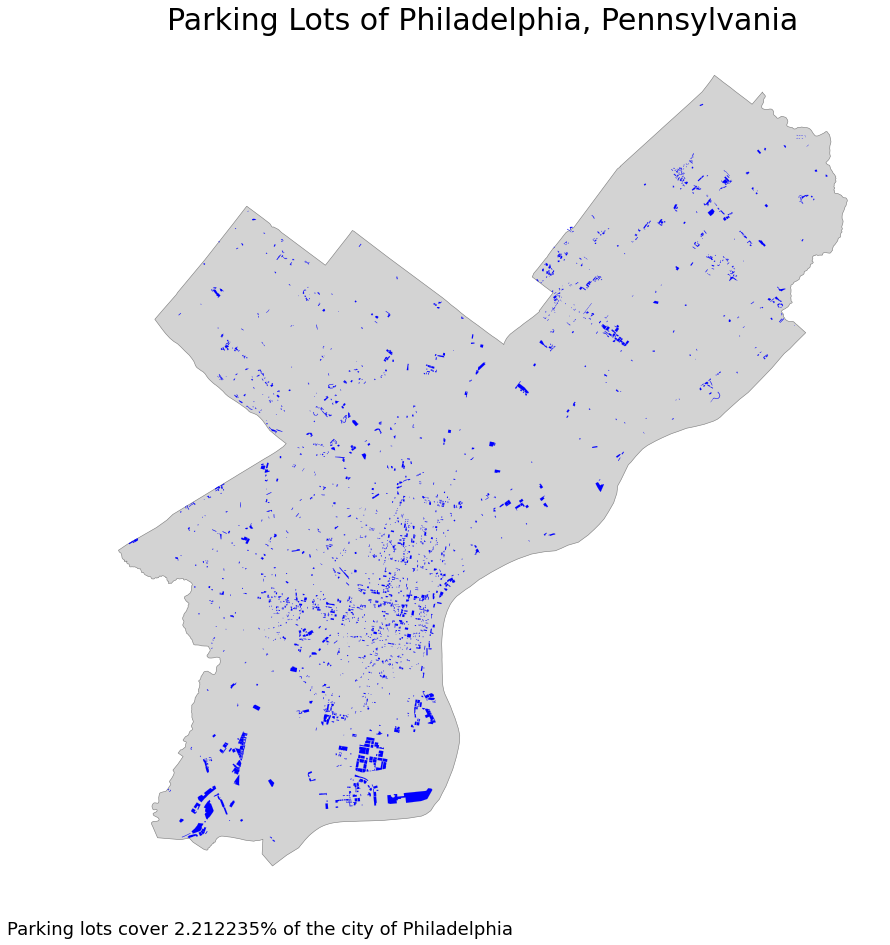

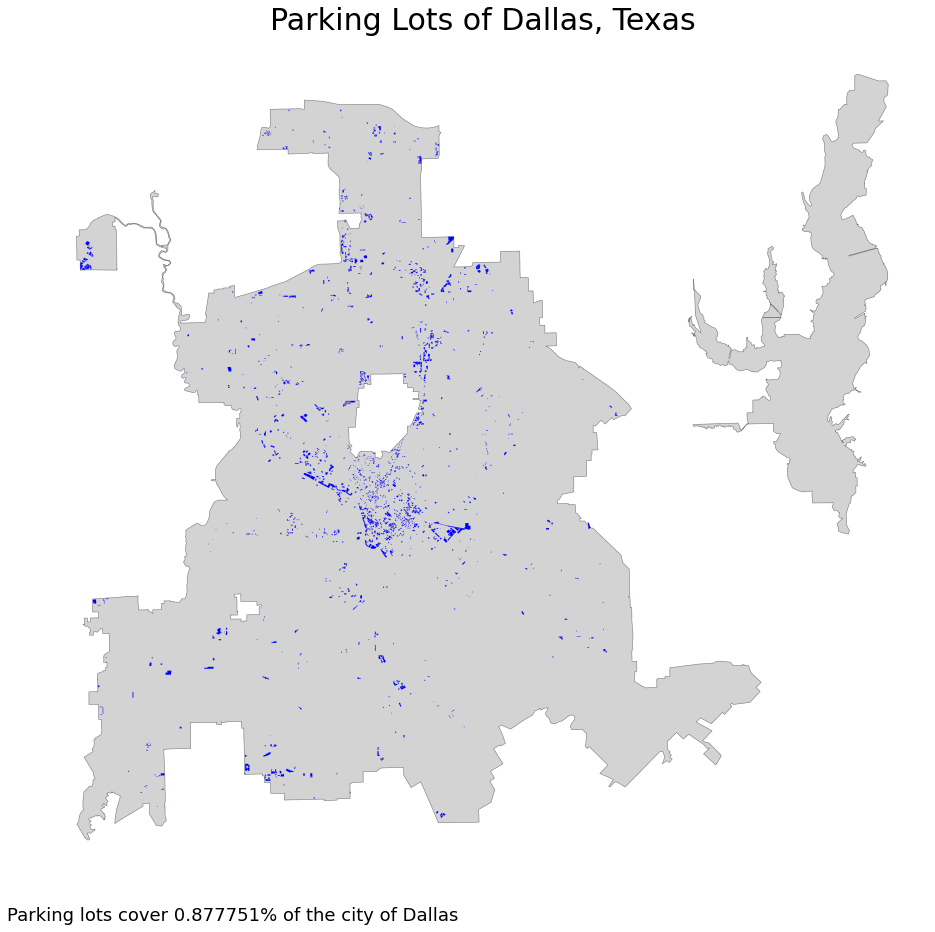

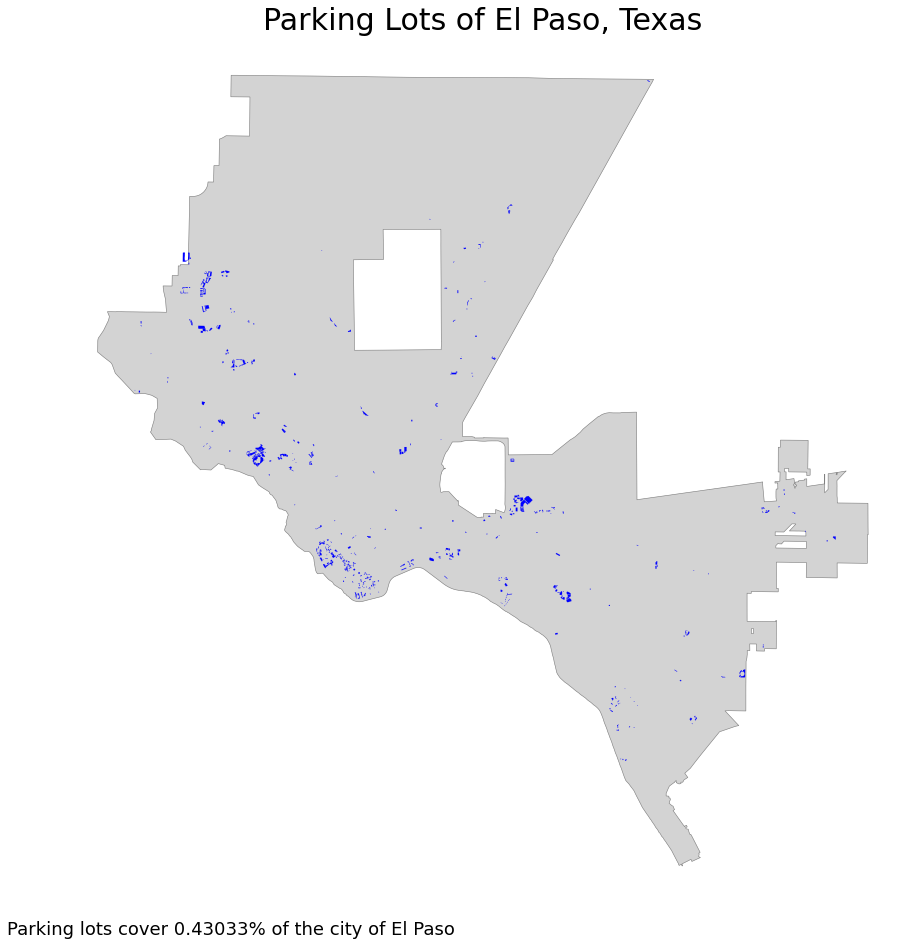

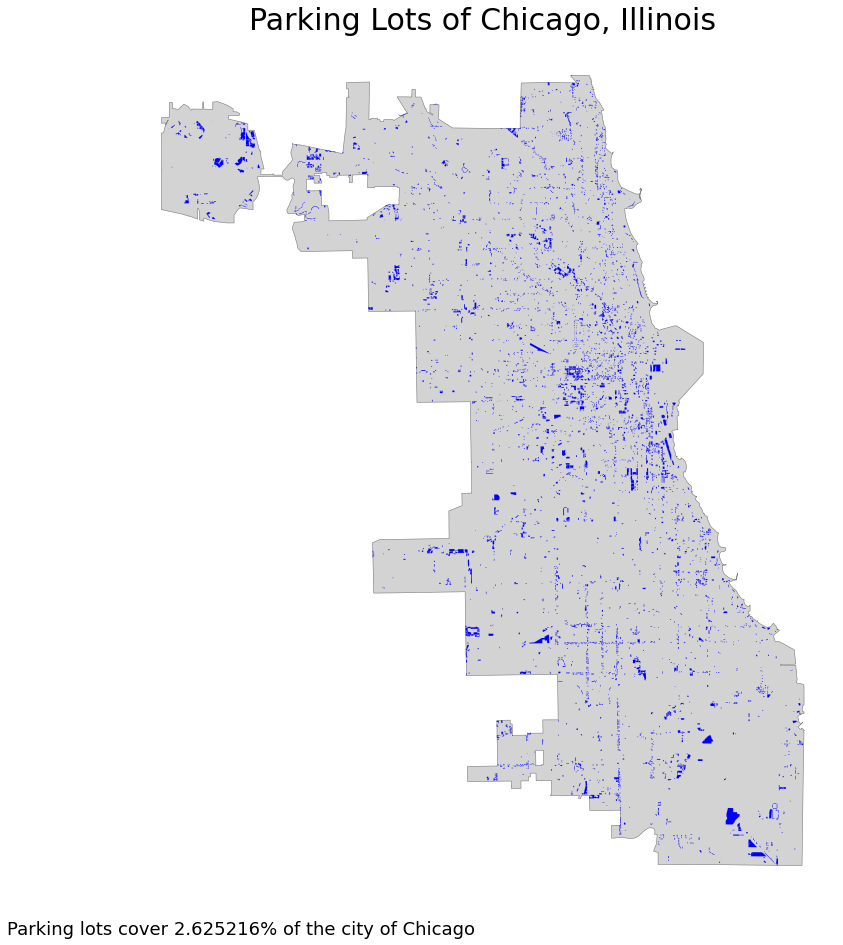

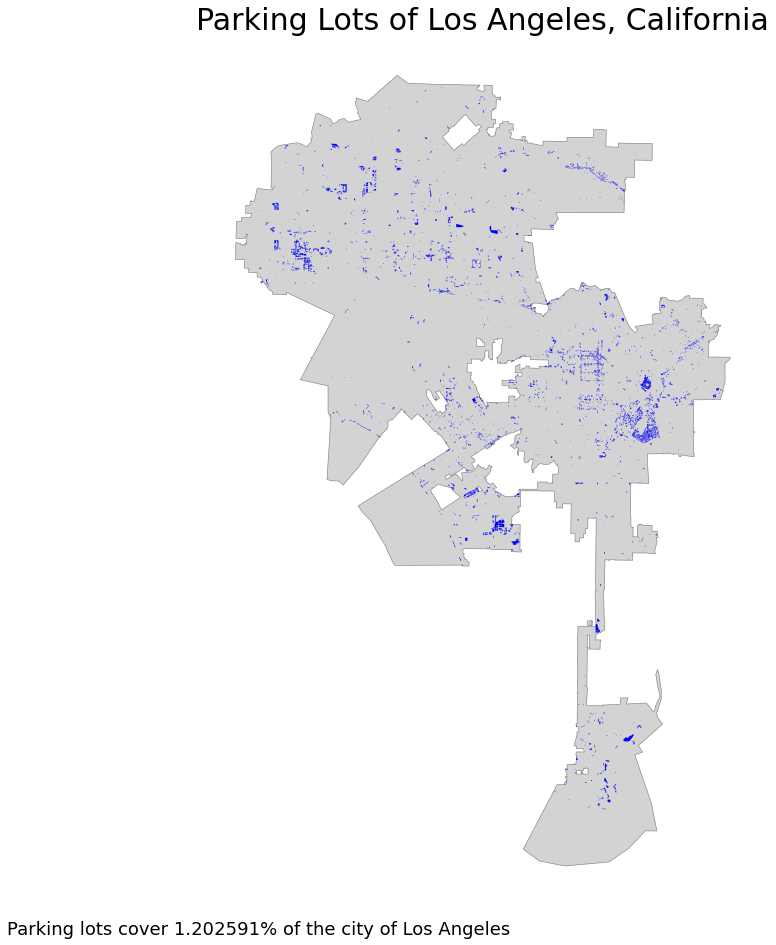

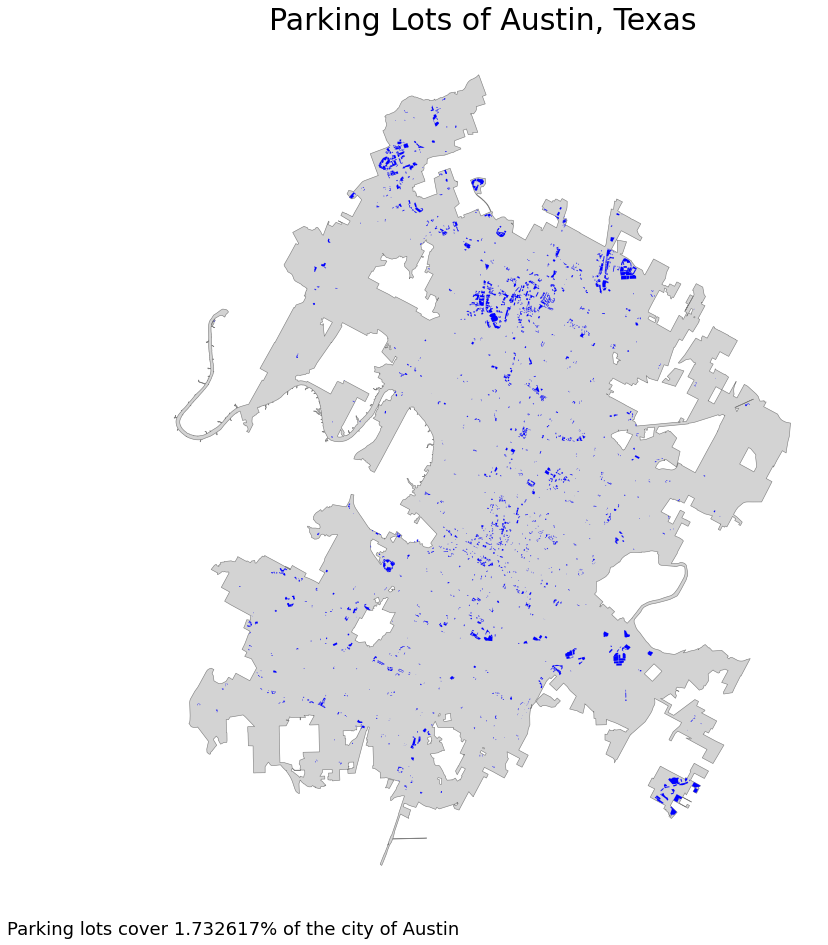

In [20]:
parking_percents = []
city_areas = []
for i in range(len(cities)):
    # Read city boundary and parking lot polygon files
    city = gpd.read_file('/Users/lily/Documents/GitHub/parking_lots/city_boundaries/' + cities[i].replace(' ', '_') + '_boundary.shp')
    parking_lots = gpd.read_file('/Users/lily/Documents/GitHub/parking_lots/parking_lots/' + cities[i].replace(' ', '_') + '_parking.shp')
    # Set CRS to WGS 84 (EPSG:4326)
    city_wgs = city.to_crs(4326)
    city_parking_wgs = parking_lots.to_crs(4326)
    # Identify city polygon coords
    coords = city_wgs.total_bounds #a tuple containing minx, miny, maxx, maxy values for the bounds of the series as a whole
    # Get UTM zone EPSG code of city
    long = coords[0]
    lat = coords[0]
    utm_zone = convert_wgs_to_utm(long, lat)
    epsg = 'EPSG:' + utm_zone
    # Correct CRS to relevant UTM
    city_utm = city_wgs.to_crs(epsg)
    parking_utm = city_parking_wgs.to_crs(epsg)
    # Calculate area of OSM city boundary
    city_area = city_utm.area
    city_areas.append(city_area
    # Calculate areas (and area percents) of each parking lot and add column to geoseries
    parking_utm['area'] = parking_utm.area
    parking_utm['area_percent'] = (parking_utm['area'] / city_area) * 100
    # Calculate sum of parking lot areas
    parking_sum = np.sum(parking_utm['area'])
    # Calculate parking lot area of city as a percent of total city area
    parking_percent = (parking_sum / city_area) * 100
    # Add percent value to list
    parking_percents.append(parking_percent)
    
    parking_data = {'City Name': ['Indianapolis','Jacksonville','Seattle','Houston','Columbus','Philadelphia','Dallas','El Paso',
                             'Chicago','Los Angeles','Austin'], 
                'Parking Lot Cover (%)': [3.477085,0.422643,1.103871,1.162967,2.30084,2.212235,0.877751,0.43033,2.625216,
                                         1.202591,1.732617]# Values taken from parking_percents list}

    parking_df = pd.DataFrame(data=parking_data)
    percent_as_string = str(parking_df.loc[i, 'Parking Lot Cover (%)'])
    
    # Data visualization
    fig, ax = plt.subplots(figsize=(16,16))
    city_utm.plot(ax=ax, color='lightgray', edgecolor='grey', linewidth=0.6)
    parking_utm.plot(ax=ax, color='blue', edgecolor='blue', linewidth=0.1)
    ax.axis('off')
    plt.title("Parking Lots of "+ cities_states[i],fontsize = 30)
    fig.text(.1,.1,"Parking lots cover " + percent_as_string + "% of the city of " + cities[i],
         fontsize=18)
    plt.savefig('/Users/lily/Documents/GitHub/parking_lots/figures/' + cities[i].replace(' ', '_') + '_parking_map.png')